### SIMOC B2 Planning

This file contains the working versions of the data_files to be used in SIMOC-B2, and a basic test of functionality.

# 1. SIMOC-B2 Data Files

### Base SIMOC Agents

In [28]:
import numpy as np
import pandas as pd
import functools, math, statistics, collections, itertools
import json

# Print all the agents we currently have with their category
current_agents = []
agent_desc = None
with open('data_files/agent_desc.json') as f:
    agent_desc = json.load(f)
    for category, agents in agent_desc.items():
        print(f'----{category}----', 
              f'\n{", ".join(agents)}' if agents else '')

----inhabitants---- 
human_agent
----eclss---- 
solid_waste_aerobic_bioreactor, urine_recycling_processor_VCD, multifiltration_purifier_post_treatment, oxygen_generation_SFWE, co2_reduction_sabatier, co2_removal_SAWD, co2_makeup_valve, particulate_removal_TCCS, dehumidifier, ch4_removal_agent
----plants---- 
rice, wheat, cabbage, chard, celery, lettuce, spinach, dry_bean, peanut, soybean, strawberry, tomato, green_onion, onion, pea, pepper, snap_bean, radish, red_beet, carrot, sweet_potato, white_potato
----isru---- 
----structures---- 
crew_habitat_sam, crew_habitat_small, crew_habitat_medium, crew_habitat_large, greenhouse_sam, greenhouse_small, greenhouse_medium, greenhouse_large, airlock, atmosphere_equalizer
----fabrication---- 
----power_generation---- 
solar_pv_array_mars, solar_pv_array_moon, wind_turbine, radioisotope_generator
----mobility---- 
----communication---- 
radio, lab_equipment
----storage---- 
air_storage, water_storage, nutrient_storage, ration_storage, food_stora

### agent_desc

Documentation: https://simoc.space/docs/user_guide/api/data-objects.html#agent-description 

Compile a new agent_desc specifically for simoc.
- All agents expected in v1
- Where possible, use the most similar SIMOC agent
- Other places, define barebones new agents with directionally-correct data

In [12]:
import copy

# Copy existing agents as placeholders where relevant
def _(_class, _agent):
    """Helper func to return default agent_desc data"""
    return copy.deepcopy(agent_desc[_class][_agent])
b2_agent_desc = {
    'inhabitants': {
        'human_agent': _('inhabitants', 'human_agent'),
    },
    'eclss': {
        'co2_removal': _('eclss', 'co2_removal_SAWD'),
        'o2_makeup_valve': {},  # Add manually below       
    },
    'plants': {        
        'rice': _('plants', 'rice'),
        'wheat': _('plants', 'wheat'),
#         'sorghum': _('plants', 'rice'),  # Placeholder
        'sweet_potato': _('plants', 'sweet_potato'),
#         'vegetables': _('plants', 'carrot'),  # Placeholder
        'soybean': _('plants', 'soybean'),
        'peanut': _('plants', 'peanut'),
#         'corn': _('plants', 'rice'),  # Placeholder
        'dry_bean': _('plants', 'dry_bean'),
#         'orchard': _('plants', 'strawberry'),  # Placeholder
    },
    'structures': {
        'b2_greenhouse': _('structures', 'greenhouse_large'), 
        'b2_crew_habitat': _('structures', 'crew_habitat_large'),
        'b2_biomes': _('structures', 'crew_habitat_large'),  # so equalizer recognized as 'habitat'
        'atm_eq_gh_crew': _('structures', 'atmosphere_equalizer'),
        'atm_eq_gh_biomes': _('structures', 'atmosphere_equalizer'),
        'soil': {},  # Add manually below
        'concrete': {},  # Add manually below
    },
    'storage': {
        'water_storage': _('storage', 'water_storage'),
        'food_storage': _('storage', 'food_storage'),
        'nutrient_storage': _('storage', 'nutrient_storage'),       
        'o2_storage': {},  # Add manually below       
    }
}

# Remove all kwh exchanges (v1 of SIMOC-B2 does not include electricity)
to_remove = []  # Make a list of tuples of paths to all kwh exchanges
for agent_class, agents in b2_agent_desc.items():
    for agent, agent_data in agents.items():
        if 'data' not in agent_data:
            continue
        for direction in ('input', 'output'):
            for i, exchange in enumerate(agent_data['data'][direction]):
                if exchange['type'] == 'kwh':
                    to_remove.append((agent_class, agent, direction, i))
for (agent_class, agent, direction, i) in to_remove:  # Delete one-by-one
    # There would be max one kwh exchange per direction, so this is safe
    del b2_agent_desc[agent_class][agent]['data'][direction][i]

# Soil
b2_agent_desc['structures']['soil'] = {
    'description': '1 m^3 of respirating organic soil.',
    'data': {
        "input": [{
            "type": "o2",
            "value": 0.037083,
            "flow_rate": {"unit": "kg", "time": "hour"},
        }],
        "output": [{
            "type": "co2",
            "value": 0.045,
            "flow_rate": {"unit": "kg", "time": "hour"},
        }],
        "characteristics": [
            {"type": "volume", "value": 1, "unit": "m^3"}]}}

# Concrete
b2_agent_desc['structures']['concrete'] = {
    'description': '1 m^3 of calcifying concrete of a specified age',
    'data': {
        "input": [{
            "type": "co2",
            "value": 0.05,
            "flow_rate": {"unit": "kg", "time": "hour"},
            "growth": {
                "lifetime": {
                    "type": "linear",
                }
            }
        }],
        "output": [],
        "characteristics": [
            {"type": "volume", "value": 1, "unit": "m^3"},
            {"type": "age_at_start", "value": 0, "unit": "hour"}]}}

# O2 Resupply System
b2_agent_desc['eclss']['o2_makeup_valve'] = {
    'description': 'Release o2 into atmosphere when it drops below 20%',
    "data": {
        "input": [{
            "type": "o2",
            "value": 0.085,
            "required": "mandatory",
            "flow_rate": {"unit": "kg", "time": "hour"},
            "criteria": {
                "name": "o2_ratio_out",
                "limit": "<",
                "value": 0.2,
                "buffer": 8}
        }],
        "output": [{
            "type": "o2",
            "value": 0.085,
            "required": "mandatory",
            "requires": ["o2"],
            "flow_rate": {"unit": "kg", "time": "hour"},
        }],    
        "characteristics": []}}
b2_agent_desc['storage']['o2_storage'] = {
    "description": "Store o2 resupply, released via makeup valve",
    "data": {
        "input": [],
        "output": [],
        "characteristics": [{
            "type": "capacity_o2",
            "value": 10000,
            "unit": "kg"}]}}
del b2_agent_desc['eclss']['co2_removal']['data']['output'][0]

# Add food_storage capacity for all plants
chars = b2_agent_desc['storage']['food_storage']['data']['characteristics']
chars = [c for c in chars if not c['type'].startswith('capacity')]
for plant in b2_agent_desc['plants']:
    chars.append({
        'type': f'capacity_{plant}',
        'value': 10_000,
        'unit': 'kg'})
b2_agent_desc['storage']['food_storage']['data']['characteristics'] = chars

### currency_desc

In [13]:
import json
from collections import defaultdict

# Load the default currency_desc
currency_desc = None
with open('data_files/currency_desc.json') as f:
    currency_desc = json.load(f)

# Make a set of the currencies used by b2 agents
required_currencies = set()
for agent_class, agents in b2_agent_desc.items():
    for agent, agent_data in agents.items():
        if 'data' not in agent_data:
            continue
        for direction in ('input', 'output'):
            for exchange in agent_data['data'][direction]:
                if exchange['type'] in currency_desc:
                    continue  # Ignore currency class exchanges
                required_currencies.add(exchange['type'])
    
# Maually add a few
required_currencies.update(('n2', 'h2', 'ch4', 'treated', 'waste'))

# Copy relevant currencies from default currency_desc
b2_currency_desc = defaultdict(dict)
for curr_class, currencies in currency_desc.items():
    for curr, cdata in currencies.items():
        if curr in required_currencies:
            b2_currency_desc[curr_class][curr] = cdata
b2_currency_desc = dict(b2_currency_desc)

# Find the missing currencies
found_currencies = set()
for currencies in b2_currency_desc.values():
    found_currencies.update(c for c in currencies)

print(f'Missing: {required_currencies.difference(found_currencies)}')

Missing: set()


### agent_conn

In [14]:
b2_agent_conn = [
    # Humans
    {'from': 'b2_crew_habitat.o2', 'to': 'human_agent.o2'},
    {'from': 'water_storage.potable', 'to': 'human_agent.potable'},
    {'from': 'food_storage.food', 'to': 'human_agent.food'},
    {'from': 'human_agent.co2', 'to': 'b2_crew_habitat.co2'},
    {'from': 'human_agent.h2o', 'to': 'b2_crew_habitat.h2o'},
    {'from': 'human_agent.urine', 'to': 'water_storage.urine'},
    {'from': 'human_agent.feces', 'to': 'water_storage.feces'},
    
    # ECLSS
    {'from': 'b2_greenhouse.co2', 'to': 'co2_removal.co2'},
    {'from': 'o2_storage.o2', 'to': 'o2_makeup_valve.o2'},
    {'from': 'o2_makeup_valve.o2', 'to': 'b2_greenhouse.o2'},
]

# Plants
for plant in b2_agent_desc['plants']:
    # Plants
    b2_agent_conn += [
      {"from": "b2_greenhouse.co2", "to": f"{plant}.co2"},
      {"from": "water_storage.potable", "to": f"{plant}.potable"},
      {"from": "nutrient_storage.fertilizer", "to": f"{plant}.fertilizer"},
      {"from": f"{plant}.biomass", "to": f"{plant}.biomass"},
      {"from": f"{plant}.inedible_biomass", "to": "nutrient_storage.inedible_biomass"},
      {"from": f"{plant}.o2", "to": "b2_greenhouse.o2"},
      {"from": f"{plant}.h2o", "to": "b2_greenhouse.h2o"},
      {"from": f"{plant}.{plant}", "to": f"food_storage.{plant}"},
    ]

# Structures
for equalizer, connection in zip(('atm_eq_gh_crew', 'atm_eq_gh_biomes'),
                                  ('b2_crew_habitat', 'b2_biomes')):
    b2_agent_conn += [
        {'from': 'b2_greenhouse.atmosphere', 'to': f'{equalizer}.atmosphere'},
        {'from': f'{connection}.atmosphere', 'to': f'{equalizer}.atmosphere'},
        {'from': f'{equalizer}.atmosphere', 'to': 'b2_greenhouse.atmosphere'},
        {'from': f'{equalizer}.atmosphere', 'to': f'{connection}.atmosphere'},
    ]
b2_agent_conn += [
    {'from': 'b2_greenhouse.co2', 'to': 'concrete.co2'},
    {'from': 'concrete.o2', 'to': 'b2_greenhouse.o2'},
    {'from': 'b2_greenhouse.o2', 'to': 'soil.o2'},
    {'from': 'soil.co2', 'to': 'b2_greenhouse.co2'},
]

### Base config
Documentation: https://simoc.space/docs/user_guide/api/data-objects.html#config

In [15]:
from agent_model.util import calc_air_storage, calc_water_storage

def volume(target):
    """Helper function to return volume from agent_desc for agent"""
    for agent_class, agents in b2_agent_desc.items():
        for agent, agent_data in agents.items():
            if agent == target:
                for char in agent_data['data']['characteristics']:
                    if char['type'] == 'volume':
                        return char['value']
    from IPython import embed; embed()
                
b2_config = {
    # Default fields
    'priorities': ['structures', 'storage', 'inhabitants', 'eclss', 'plants'],
    'seed': 12345,
    'global_entropy': 0,
    'location': 'earth',
    'minutes_per_step': 60,
    'single_agent': 1,

    # Adjustable Fields
    'termination': [{'condition': 'time', 'value': 365, 'unit': 'day',}],
    'agents': {
        
        # Inhabitants
        'human_agent': {'amount': 1},
        'soil': {'amount': 1},
        
        # ECLSS
        'co2_removal': {'amount': 1},
        'o2_makeup_valve': {'amount': 1},
        
        # Plants
        'rice': {'amount': 80},
        'wheat': {'amount': 80},
#         'sorghum': {'amount': 80},
        'sweet_potato': {'amount': 80},
#         'vegetables': {'amount': 80},
        'soybean': {'amount': 80},
        'peanut': {'amount': 80},
#         'corn': {'amount': 80},
        'dry_bean': {'amount': 80},
#         'orchard': {'amount': 80},
        
        # Structures
        'b2_greenhouse': calc_air_storage(volume('b2_greenhouse')),
        'b2_crew_habitat': calc_air_storage(volume('b2_crew_habitat')),
        'b2_biomes': calc_air_storage(volume('b2_biomes')),
        'atm_eq_gh_crew': {'amount': 1},
        'atm_eq_gh_biomes': {'amount': 1},
        'concrete': {'amount': 1},
        
        # Storage
        'water_storage': calc_water_storage(volume('water_storage')),
        'nutrient_storage': {'amount': 1, "fertilizer": 10_000},
        'food_storage': {plant: 50 for plant in b2_agent_desc['plants']},
        'o2_storage': {'o2': 2_000},
    }
}

### Run in SIMOC

In [16]:
import matplotlib.pyplot as plt

# A helper function to plot all elements in a group.
def plot_group(group, exclude=[], i=None, j=None):
    plt.figure(figsize=(12,6))
    length = len(next(iter(group.values())))
    i = i if i else 0
    j = j if j else length-1
    steps = [i for i in range(j-i)]
    for currency, values in group.items():
        if sum(values) == 0 or currency in exclude:
            continue
        plt.plot(steps, values[i:j], label=currency)
    plt.legend()
    plt.show()
    
def plot_currency(data, currency, exclude=[], i=None, j=None):
    """Plot all agents who use a particular currency"""
    
    # Iterate through data and extract all records
    flows = {}
    length = None
    for agent_name, agent_data in data.items():
        if 'flow_records' not in agent_data:
            continue
        for currency_name, currency_data in agent_data['flow_records'].items():
            if currency_name != currency:
                continue
            flow_records = {}
            if not length:
                length = len(currency_data)
            for n, step in enumerate(currency_data):
                # Steps can include records for multiple currencies, 
                # or multiple records for the same currency
                at_least_one = False
                for record in step:
                    if agent_name not in flows:
                        flows[agent_name] = [] + [0] * n
                    if not at_least_one:
                        at_least_one = True
                        flows[agent_name].append(-record['amount'])
                    else:
                        flows[agent_name][-1] -= record['amount']
                if not at_least_one and agent_name in flows:
                    flows[agent_name].append(0)
    
    if not length:
        print("No flow records for", currency)
        return
    
    # Plot data
    plt.figure(figsize=(12,6))
    i = i if i else 0
    j = j if j else length
    steps = [x for x in range(j-i)]
    for agent_name, agent_data in flows.items():
        if agent_name in exclude:
            continue
        pad_zeros = len(steps) - len(agent_data)
        if pad_zeros > 0:
            agent_data += [0] * pad_zeros
        plt.plot(steps, agent_data[i:j], label=agent_name)
    plt.legend(loc='lower right')
    plt.show()

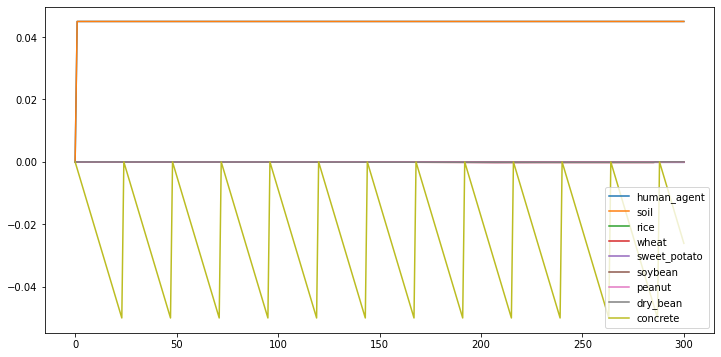

In [17]:
from agent_model import AgentModel
import matplotlib.pyplot as plt

simoc = AgentModel.from_config(
    b2_config, 
    data_collection=True,
    currency_desc=b2_currency_desc,
    agent_desc=b2_agent_desc,
    agent_conn=b2_agent_conn,
    agent_variation=None,
    agent_events=None,
    merge=False
)

simoc.step_to(n_steps=300)
data = simoc.get_data(debug=True)
plot_currency(data, 'co2')

# 2. Validation Data
- List all inputs and expected outputs with their original reference.
- Write tests to evaluate the model against all those outputs
- Build a loss function for outputs to make it trainable

In [18]:
# Dates / General
mission_1a_start_date = '1991-09-26'
mission_1b_start_date = '1993-01-12'  # Day 475, pure O2 added
mission_1_end_date = '1993-09-25'
mission_1_crew_size = 8

mission_2_start_date = '1994-03-06'
mission_2_end_date = '1994-09-06'
mission_2_end_date_original = '1995-01-06'
mission_2_crew_size = 7

Text(0, 0.5, '')

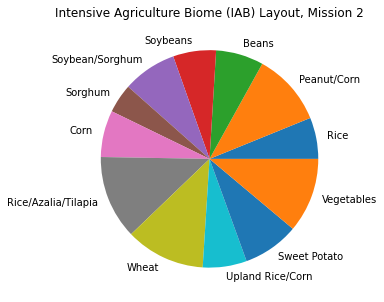

In [123]:
# Marino et. al. The Agricuultural biome of Biosphere 2: Structure, compostion and function
# Page 202: Design and description
iab_soil_volume = 2_000  # m2
data = [
    # Plot, area, crop
    (1, 69, 'Rice/Azalia/Tilapia'),
    (2, 56, 'Wheat'),
    (3, 55, 'Sorghum'),
    (4, 45, 'Peanut/Corn'),
    (5, 40, 'Beans'),
    (6, 52, 'Sweet Potato'),
    (7, 54, 'Sweet Potato'),
    (8, 50, 'Beans'),
    (9, 60, 'Vegetables'),
    (10, 89, 'Rice/Azalia/Tilapia'),
    (11, 81, 'Soybeans'),
    (12, 88, 'Corn'),
    (13, 94, 'Wheat'),
    (14, 81, 'Vegetables'),
    (15, 78, 'Rice'),
    (16, 83, 'Upland Rice/Corn'),
    (17, 102, 'Soybean/Sorghum'),
    (18, 92, 'Peanut/Corn')]

# p214: "By the last quarter of Mission 1, approximately 65% of the 
# agricultural area was planted in only three crops: beet, sweet potato 
# and lab-lab bean."
mission_2_staple_ratio = 0.65

# Merge plots of same crop for the chart
unique_plants = set([d[2] for d in data])
total_areas = {p:0 for p in unique_plants}
for plot, area, crop in data:
    total_areas[crop] += area
iab = pd.DataFrame(list(total_areas.values()), 
                   index=list(total_areas.keys()), 
                   columns=['area'])
ax = iab['area'].plot.pie(figsize=(5, 5))
ax.set_title('Intensive Agriculture Biome (IAB) Layout, Mission 2')

ax.set_ylabel('')

Text(0.5, 1.0, 'Selected Plant Productivity, day 0-600')

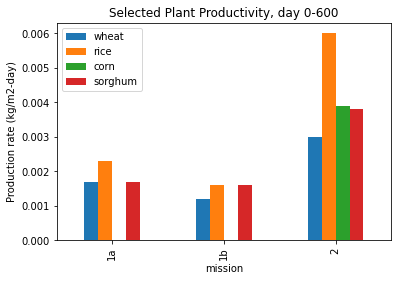

In [124]:
# Marino et. al. The Agricuultural biome of Biosphere 2: Structure, compostion and function
# Page 220: Comparisons of plant productivity for selected IAB and CELSS crops
cols = ['mission', 'wheat', 'rice', 'corn', 'sorghum']
data = [('1a', 0.0017, 0.0023, 0, 0.0017),
       ('1b', .0012, 0.0016, 0, 0.0016),
       ('2', 0.003, 0.006, 0.0039, 0.0038)]

production_rate = pd.DataFrame(data, columns=cols)
ax = production_rate.plot.bar(x='mission')
ax.set_ylabel('Production rate (kg/m2-day)')
ax.set_title('Selected Plant Productivity, day 0-600')

label
co2                AxesSubplot(0.125,0.2;0.775x0.68)
co2_in_scrubber    AxesSubplot(0.125,0.2;0.775x0.68)
o2                 AxesSubplot(0.125,0.2;0.775x0.68)
Name: moles, dtype: object

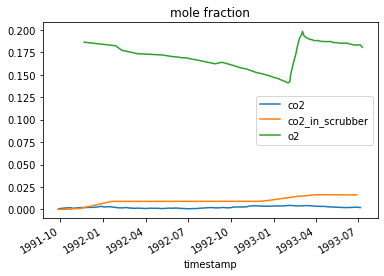

In [22]:
# Severignhaus et al. Atmospheric Budget for Biosphere 2,  Sept. 26, 1991 - June 7, 1993
# Daily o2 and co2 data, estimated from graphic (p1)
data_files_path = 'simoc_server/test/b2_data_files/'
fnames = [('o2', 'severinghaus_o2_datapoints.csv'), 
          ('co2', 'severinghaus_co2_datapoints.csv'),
          ('co2_in_scrubber', 'severinghaus_co2_offset_datapoints.csv')]
moles = pd.DataFrame([])
for var, fname in fnames:
    df = pd.read_csv(data_files_path + fname, header=None)
    df.columns = ['julian', 'moles']
    df['label'] = var
    
    df['timestamp'] = pd.to_datetime(mission_1a_start_date)  # Create timestamp column
    time_delta = pd.to_timedelta(df['julian'], unit='D')  # julian -> timedelta
    df['timestamp'] += time_delta  # Add timedelta to timestamp
    moles = pd.concat([moles, df], axis=0)  # Add to all records
    
    
moles.set_index('timestamp').groupby('label').moles.plot(
    legend=True, title='mole fraction')

<Figure size 432x288 with 0 Axes>

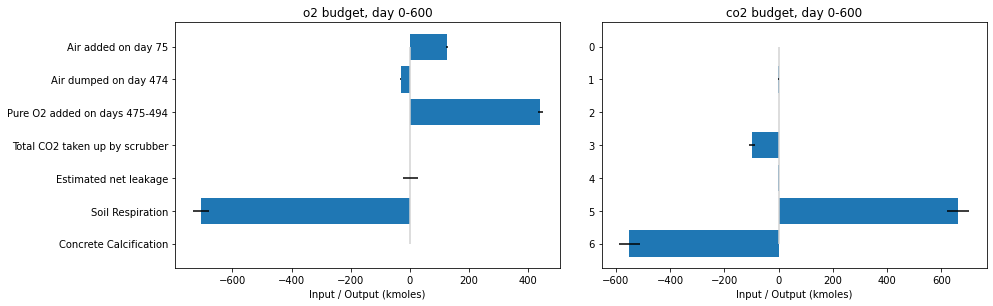

In [125]:
# Severignhaus et al. Atmospheric Budget for Biosphere 2,  Sept. 26, 1991 - June 7, 1993
# Table 1: Known inputs and outputs
cols = ['description', 'o2_kmoles', 'o2_uncertainty', 'co2_kmoles', 'co2_uncertainty']
data = [('Air added on day 75', 126, 4, 0, 0),
        ('Air dumped on day 474', -31, 2, -1, 1),
        ('Pure O2 added on days 475-494', 441, 8, 0, 0),
        ('Total CO2 taken up by scrubber', 0, 0, -98, 10),
        ('Estimated net leakage', 2, 24, -2, 1),
        ('Soil Respiration', -708, 27, 662, 40),
        ('Concrete Calcification', 0, 0, -550, 38),]
table_1 = pd.DataFrame(data, columns=cols)
table_1.head()

plt.subplots_adjust(wspace=10)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout()
y_pos = range(table_1.shape[0])
for i, currency in enumerate(('o2', 'co2')):
    ax[i].vlines(0, 0, 6, colors='lightgray')
    ax[i].barh(y_pos, 
               table_1[f'{currency}_kmoles'], 
               xerr=table_1[f'{currency}_uncertainty'], 
               align='center')
    if i == 0:
        ax[i].set_yticks(y_pos, labels=table_1['description'])
    ax[i].invert_yaxis()  # labels read top-to-bottom
    ax[i].set_xlabel('Input / Output (kmoles)')
    ax[i].set_title(f'{currency} budget, day 0-600')

# 3. B2 presets

The starting agents and quantities for:
1. Mission 1a: The initial mission without o2 resupply
2. Mission 1b: The initial mission beginning at the time o2 resupply is added
3. Mission 2: The second mission (after a several-month break)

In [ ]:
# Everything except 'agents'
default_config = {
    'termination': [{
        'condition': 'time',
        'value': 365,
        'unit': 'day',
    }],
    'priorities': [
        'structures', 'storage', 'inhabitants', 'eclss', 'plants'
    ],
    'seed': 12345,
    'global_entropy': 0,
    'location': 'earth',
    'minutes_per_step': 60,
    'single_agent': 1,
}


# The original mission:
# - Humans: amount, weight, rates of metabolism / respiration
# - Structures: volume & composition of atmosphere
# - Plants: which species (limit to those listed above), amount (area)
# - Pests: any data related to the affect of pests
config_mission_1a = {
    **default_config,
    'agents': {
        'human_agent': {
            'amount': 1,
        }
    },
}

# Figure 3 shows the comparison of yields between mission 1 and 2,
# Mission 1
# Rice 2.4 MT/ha
# Wheat 1.8 MT/ha
# Corn 0 MT/ha
# Sorghum 2.1 MT/ha
# Soybean 2.5 MT/ha

# The original mission from the time o2 is added
# - What day was it added? Duration?
# - Starting atmosphere, currencies, agents should match mission_1a at that time
# - Reconfigured greenhouse, much simplified. Amount, species



# - O2 in from storage (mimic the CO2 resupply valve)
config_mission_1b = {
    **default_config,
    'agents': {
        'human_agent': {
            'amount': 1,
        }
    },
}

# The second mission, things went much better
# - How long after the start of mission_1a?
# - How is garden reconfigured

# Per Figure 1 in Marino et. al, this configuration is 1994
# Rice / Azolla / Tilapia 69+89 m^2 -- Plots 1,10
# Wheat 56+94 m ^2                  -- Plots 2,13
# Sorghum 55 m^2                    -- Plot 3
# Peanut / Corn 45 m ^2             -- Plot 4
# Beans 40+90 m^2                   -- Plots 5,8
# Sweet Potato 52+54 m^2            -- Plots 6,7
# "Vegetables" 60+81 m^2            -- Plots 9,14 
# Soybeans 81 m^2                   -- Plot 11
# Corn 88 m^2                       -- Plot 12
# Rice 78 m^2                       -- Plot 15
# Upland Rice / Corn 83 m^2         -- Plot 16
# Sorghum / Soybean 102 m^2         -- Plot 17
# Peanut / Corn 82 m^2              -- Plot 18

# Table 1 shows that mission 2 eliminates:
#  kale, kohlrabi,  peas,  plantains, winter squash, tumeric, loquat, coconut,
# cacao, grape, pineapple, apple, grape, kumquat, acerola, Bay Tree,

# Mission 2 adds:
# mustard leaf, garlic, okra, sponge gourd, pumpkin, bottle gourd, zucchini, oregano,
# Coriander, Parsley, Rosemary, Fennel, Ginger, and Tapioca, rice beans, kidney beans,
# navy beans, lima beans, 

# Table 1 also shows a variety of plants that were maintained in both missions without
# elaborating on quantities due to being in the orchard or balconies

# Figure 3 shows the comparison of yields between mission 1 and 2,
# Mission 2
# Rice 7.4 MT/ha
# Wheat 3.5 MT/ha
# Corn 4 MT/ha
# Sorghum 4.5 MT/ha
# Soybean 2 MT/ha
 

# - Predators: any information about which predators and their impact
# - How much additional time spent weeding?
config_mission_2 = {
    **default_config,
    'agents': {
        'human_agent': {
            'amount': 1,
        }
    },
}